In [109]:
import pandas as pd
import numpy as np


In [110]:
import sys
sys.path.append("../") 

In [111]:
import os
file_path = "../data/converted_transactions_thieu_enriched.csv"  # Đường dẫn đến file CSV
# Lấy tên file không kèm đường dẫn
file_name = os.path.basename(file_path)             
# Lấy tên file không có phần mở rộng
base_name = os.path.splitext(file_name)[0]         
print(base_name)  

converted_transactions_thieu_enriched


In [112]:
from data_processorV4 import DataProcessorV4

processor = DataProcessorV4()
# Bây giờ mới transform dữ liệu mới
df_new = pd.read_csv(file_path, encoding="latin-1") 
new_windows = processor.transform_new_data(df_new, "v_20251013_203451")
print(new_windows.shape)

Processors not loaded. Loading version 'v_20251013_203451'...
✅ Loaded processors from version 'v_20251013_203451'
(199, 20, 16)


In [120]:
SEQ_LEN = new_windows.shape[1]
INPUT_DIM = new_windows.shape[2]
print(SEQ_LEN, INPUT_DIM)

20 16


In [114]:
#load mô hình
from tensorflow import keras
from train_model_V3 import LSTMAutoencoderTrainer

trainer = LSTMAutoencoderTrainer(seq_len=SEQ_LEN, input_dim=INPUT_DIM)
trainer.load_model("models/autoencoderV4_pro_model.keras")


✅ Model loaded from models/autoencoderV4_pro_model.keras


In [115]:
reconstructions = trainer.model.predict(new_windows)

mse = np.mean(np.power(new_windows - reconstructions, 2), axis=(1, 2))
print("MSE shape:", mse.shape)
print("MSE sample:", mse[:10])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
MSE shape: (199,)
MSE sample: [0.04919281 0.04431424 0.04616188 0.04715228 0.05344517 0.05321165
 0.05177917 0.04801941 0.05061704 0.04847916]


In [116]:
#chuyển đổi sang rmse cho dễ hiểu
rmse = np.sqrt(mse)
# In kết quả để so sánh
print("\n--- Chuyển đổi sang RMSE ---")
print(f"MSE sample: {mse[:10]}")
print(f"RMSE sample: {rmse[:10]}")


--- Chuyển đổi sang RMSE ---
MSE sample: [0.04919281 0.04431424 0.04616188 0.04715228 0.05344517 0.05321165
 0.05177917 0.04801941 0.05061704 0.04847916]
RMSE sample: [0.22179452 0.21050948 0.21485317 0.21714576 0.23118211 0.2306765
 0.22755037 0.21913332 0.2249823  0.22017984]


In [117]:
# load tất cả các ngưỡng
threshold_95 = trainer.load_threshold("models/lstm_threshold_V4_95.pkl")
threshold_95 = trainer.threshold
threshold_98 = trainer.load_threshold("models/lstm_threshold_V4_98.pkl")
threshold_98 = trainer.threshold
threshold_99 = trainer.load_threshold("models/lstm_threshold_V4_99.pkl")
threshold_99 = trainer.threshold


✅ Threshold loaded from models/lstm_threshold_V4_95.pkl. Value: 0.0235
✅ Threshold loaded from models/lstm_threshold_V4_98.pkl. Value: 0.0323
✅ Threshold loaded from models/lstm_threshold_V4_99.pkl. Value: 0.0403


In [118]:
thresholds = {
    95: threshold_95,
    98: threshold_98,
    99: threshold_99
}

# Giả sử các biến thresholds, mse, df_new, và base_name đã được định nghĩa ở trên

# Tính toán độ lệch (số dòng đầu tiên không có MSE)
# Chỉ cần tính một lần bên ngoài vòng lặp
offset = len(df_new) - len(mse)

# Tạo một DataFrame mới đã được căn chỉnh với mảng mse
df_to_filter = df_new.iloc[offset:]

# Lặp qua từng ngưỡng
for t in thresholds:
    print(f"Đang xử lý với ngưỡng (Threshold) {t}...")
    
    anomalies_mask = mse > thresholds[t]
    
    # --- 1. Lọc và lưu file BẤT THƯỜNG (vượt ngưỡng) ---
    num_anomalies = np.sum(anomalies_mask)
    print(f"Số lượng giao dịch Bất thường (vượt ngưỡng): {num_anomalies}")
    
    # Dùng df_to_filter đã được căn chỉnh để lọc <--- THAY ĐỔI QUAN TRỌNG
    anomalous_transactions = df_to_filter[anomalies_mask]
    
    out_file_anomaly = f"{base_name}_{t}_anomaly.csv"
    anomalous_transactions.to_csv(out_file_anomaly, index=False)
    print(f"✅ Đã lưu file Bất thường: {out_file_anomaly}")
    
    # --- 2. Lọc và lưu file BÌNH THƯỜNG (không vượt ngưỡng) ---
    normal_mask = ~anomalies_mask
    
    num_normal = np.sum(normal_mask)
    print(f"Số lượng giao dịch Bình thường (không vượt ngưỡng): {num_normal}")

    # Dùng df_to_filter đã được căn chỉnh để lọc <--- THAY ĐỔI QUAN TRỌNG
    normal_transactions = df_to_filter[normal_mask]
    
    out_file_normal = f"{base_name}_{t}_normal.csv"
    normal_transactions.to_csv(out_file_normal, index=False)
    print(f"✅ Đã lưu file Bình thường: {out_file_normal}")
    
    print("-" * 50)

Đang xử lý với ngưỡng (Threshold) 95...
Số lượng giao dịch Bất thường (vượt ngưỡng): 199
✅ Đã lưu file Bất thường: converted_transactions_thieu_enriched_95_anomaly.csv
Số lượng giao dịch Bình thường (không vượt ngưỡng): 0
✅ Đã lưu file Bình thường: converted_transactions_thieu_enriched_95_normal.csv
--------------------------------------------------
Đang xử lý với ngưỡng (Threshold) 98...
Số lượng giao dịch Bất thường (vượt ngưỡng): 185
✅ Đã lưu file Bất thường: converted_transactions_thieu_enriched_98_anomaly.csv
Số lượng giao dịch Bình thường (không vượt ngưỡng): 14
✅ Đã lưu file Bình thường: converted_transactions_thieu_enriched_98_normal.csv
--------------------------------------------------
Đang xử lý với ngưỡng (Threshold) 99...
Số lượng giao dịch Bất thường (vượt ngưỡng): 114
✅ Đã lưu file Bất thường: converted_transactions_thieu_enriched_99_anomaly.csv
Số lượng giao dịch Bình thường (không vượt ngưỡng): 85
✅ Đã lưu file Bình thường: converted_transactions_thieu_enriched_99_norm

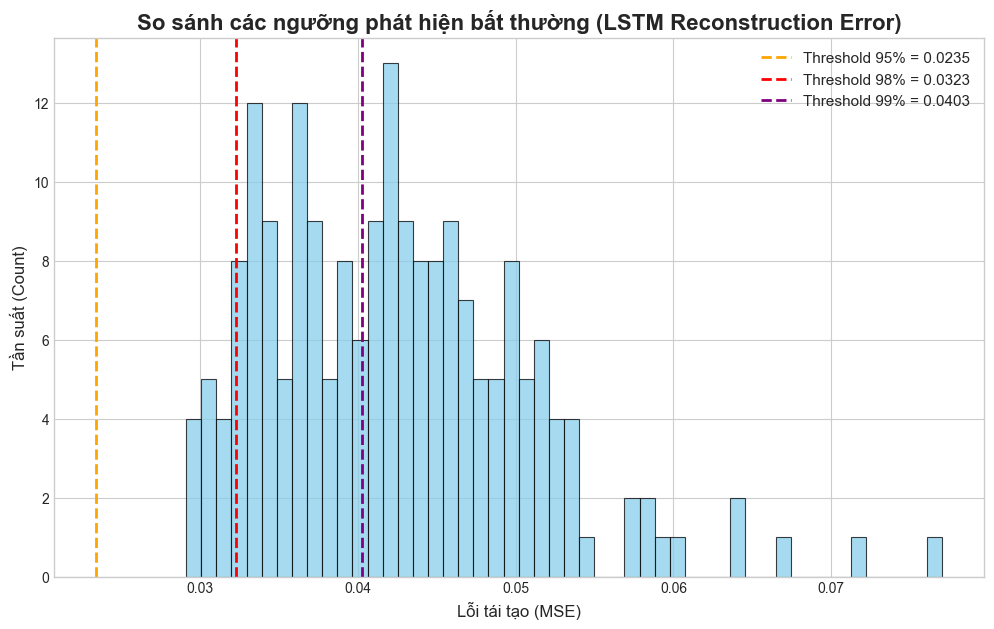

In [119]:
import matplotlib.pyplot as plt

# Giả sử bạn đã có các biến:
# mse, threshold_95, threshold_98, threshold_99

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

# Vẽ histogram lỗi tái tạo
plt.hist(
    mse,
    bins=50,
    alpha=0.75,
    edgecolor='black',
    linewidth=0.8,
    color='skyblue'
)

# Vẽ 3 đường ngưỡng để so sánh
plt.axvline(threshold_95, color='orange', linestyle='--', linewidth=2, label=f'Threshold 95% = {threshold_95:.4f}')
plt.axvline(threshold_98, color='red', linestyle='--', linewidth=2, label=f'Threshold 98% = {threshold_98:.4f}')
plt.axvline(threshold_99, color='purple', linestyle='--', linewidth=2, label=f'Threshold 99% = {threshold_99:.4f}')

# Tiêu đề và nhãn
plt.title("So sánh các ngưỡng phát hiện bất thường (LSTM Reconstruction Error)", fontsize=16, fontweight='bold')
plt.xlabel("Lỗi tái tạo (MSE)", fontsize=12)
plt.ylabel("Tần suất (Count)", fontsize=12)

# Hiển thị chú thích
plt.legend(fontsize=11, loc='upper right')

# Hiển thị biểu đồ
plt.show()


In [122]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from tensorflow import keras

sys.path.append("../") 
from data_processorV4 import DataProcessorV4
from train_model_V3 import LSTMAutoencoderTrainer

# --- 1. CÀI ĐẶT CÁC THAM SỐ VÀ TẢI MÔ HÌNH (CHỈ LÀM MỘT LẦN) ---

# Đường dẫn đến các thư mục
DATA_DIRECTORY = "../data/"
OUTPUT_BASE_DIRECTORY = "test_results/" # Thư mục gốc để lưu tất cả kết quả
MODEL_PATH = "models/autoencoderV4_pro_model.keras"

# Khởi tạo các đối tượng xử lý và trainer
processor = DataProcessorV4()

# Xác định SEQ_LEN và INPUT_DIM từ một file mẫu hoặc hardcode nếu bạn biết trước
# Ở đây ta sẽ xác định lại trong vòng lặp vì mỗi file có thể có số dòng khác nhau
# nên SEQ_LEN sẽ được cập nhật. INPUT_DIM thì thường không đổi.
# Giả sử INPUT_DIM không đổi qua các file
INPUT_DIM = 20 # << CẬP NHẬT: Bạn cần đặt số chiều đầu vào chính xác ở đây
SEQ_LEN = 16   # << CẬP NHẬT: Đặt một giá trị mặc định, sẽ được cập nhật sau

trainer = LSTMAutoencoderTrainer(seq_len=SEQ_LEN, input_dim=INPUT_DIM)
trainer.load_model(MODEL_PATH)

# Tải tất cả các ngưỡng một lần
print("Đang tải các ngưỡng (thresholds)...")
# load tất cả các ngưỡng
threshold_95 = trainer.load_threshold("models/lstm_threshold_V4_95.pkl")
threshold_95 = trainer.threshold
threshold_98 = trainer.load_threshold("models/lstm_threshold_V4_98.pkl")
threshold_98 = trainer.threshold
threshold_99 = trainer.load_threshold("models/lstm_threshold_V4_99.pkl")
threshold_99 = trainer.threshold
thresholds = {
    95: threshold_95,
    98: threshold_98,
    99: threshold_99
}
print("Tải ngưỡng thành công!")

# --- 2. BẮT ĐẦU VÒNG LẶP XỬ LÝ TẤT CẢ CÁC FILE TRONG THƯ MỤC DATA ---

# Lấy danh sách tất cả các file trong thư mục dữ liệu
try:
    all_files = os.listdir(DATA_DIRECTORY)
except FileNotFoundError:
    print(f"LỖI: Thư mục '{DATA_DIRECTORY}' không tồn tại. Vui lòng kiểm tra lại đường dẫn.")
    sys.exit()

# Lọc chỉ lấy các file .csv
csv_files = [f for f in all_files if f.endswith('.csv')]

if not csv_files:
    print(f"Không tìm thấy file .csv nào trong thư mục '{DATA_DIRECTORY}'.")
else:
    print(f"Tìm thấy {len(csv_files)} file .csv. Bắt đầu xử lý...")

# Lặp qua từng file csv
for file_name in csv_files:
    file_path = os.path.join(DATA_DIRECTORY, file_name)
    base_name = os.path.splitext(file_name)[0]
    
    print("\n" + "="*60)
    print(f"🚀 Đang xử lý file: {file_name}")
    print("="*60)

    # Tạo thư mục riêng cho kết quả của file này
    output_folder_for_file = os.path.join(OUTPUT_BASE_DIRECTORY, base_name)
    os.makedirs(output_folder_for_file, exist_ok=True)
    print(f"Thư mục kết quả được tạo tại: {output_folder_for_file}")

    # a. Đọc và xử lý dữ liệu từ file hiện tại
    try:
        df_new = pd.read_csv(file_path, encoding="latin-1")
        if df_new.empty:
            print(f"⚠️ Cảnh báo: File '{file_name}' rỗng. Bỏ qua file này.")
            continue # Chuyển sang file tiếp theo

        new_windows = processor.transform_new_data(df_new, "v_20251013_203451")
        print(f"Kích thước dữ liệu sau khi xử lý (windows): {new_windows.shape}")
        
        if new_windows.shape[0] == 0:
            print(f"⚠️ Cảnh báo: Không thể tạo cửa sổ dữ liệu từ file '{file_name}'. Bỏ qua file này.")
            continue

    except Exception as e:
        print(f"❌ Lỗi khi đọc hoặc xử lý file '{file_name}': {e}")
        continue # Bỏ qua file lỗi và xử lý file tiếp theo

    # b. Dự đoán và tính toán lỗi
    reconstructions = trainer.model.predict(new_windows)
    mse = np.mean(np.power(new_windows - reconstructions, 2), axis=(1, 2))

    # c. Lọc và lưu kết quả bất thường/bình thường cho từng ngưỡng
    offset = len(df_new) - len(mse)
    df_to_filter = df_new.iloc[offset:].copy() # Dùng .copy() để tránh SettingWithCopyWarning
    df_to_filter['reconstruction_error_mse'] = mse # Thêm cột lỗi để tham khảo

    for t_value, threshold_val in thresholds.items():
        print(f"\n--- Xử lý với ngưỡng {t_value}% (giá trị: {threshold_val:.6f}) ---")
        
        anomalies_mask = mse > threshold_val
        
        # Lưu file bất thường
        anomalous_transactions = df_to_filter[anomalies_mask]
        num_anomalies = len(anomalous_transactions)
        out_file_anomaly = os.path.join(output_folder_for_file, f"{base_name}_{t_value}_anomaly.csv")
        anomalous_transactions.to_csv(out_file_anomaly, index=False)
        print(f"Số lượng bất thường: {num_anomalies} -> Đã lưu tại: {out_file_anomaly}")
        
        # Lưu file bình thường
        normal_transactions = df_to_filter[~anomalies_mask]
        num_normal = len(normal_transactions)
        out_file_normal = os.path.join(output_folder_for_file, f"{base_name}_{t_value}_normal.csv")
        normal_transactions.to_csv(out_file_normal, index=False)
        print(f"Số lượng bình thường: {num_normal} -> Đã lưu tại: {out_file_normal}")

    # d. Vẽ và lưu biểu đồ
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    
    plt.hist(mse, bins=50, alpha=0.75, edgecolor='black', linewidth=0.8, color='skyblue')
    
    plt.axvline(thresholds[95], color='orange', linestyle='--', linewidth=2, label=f'Threshold 95% = {thresholds[95]:.4f}')
    plt.axvline(thresholds[98], color='red', linestyle='--', linewidth=2, label=f'Threshold 98% = {thresholds[98]:.4f}')
    plt.axvline(thresholds[99], color='purple', linestyle='--', linewidth=2, label=f'Threshold 99% = {thresholds[99]:.4f}')
    
    plt.title(f"Phân phối lỗi tái tạo cho file: {file_name}", fontsize=16, fontweight='bold')
    plt.xlabel("Lỗi tái tạo (MSE)", fontsize=12)
    plt.ylabel("Tần suất (Count)", fontsize=12)
    plt.legend(fontsize=11, loc='upper right')
    
    # Lưu biểu đồ thay vì hiển thị
    plot_path = os.path.join(output_folder_for_file, f"{base_name}_reconstruction_error_histogram.png")
    plt.savefig(plot_path)
    plt.close() # Đóng biểu đồ để giải phóng bộ nhớ và tránh chồng chéo
    print(f"\n✅ Biểu đồ đã được lưu tại: {plot_path}")

print("\n🎉 Hoàn tất xử lý tất cả các file! 🎉")

✅ Model loaded from models/autoencoderV4_pro_model.keras
Đang tải các ngưỡng (thresholds)...
✅ Threshold loaded from models/lstm_threshold_V4_95.pkl. Value: 0.0235
✅ Threshold loaded from models/lstm_threshold_V4_98.pkl. Value: 0.0323
✅ Threshold loaded from models/lstm_threshold_V4_99.pkl. Value: 0.0403
Tải ngưỡng thành công!
Tìm thấy 43 file .csv. Bắt đầu xử lý...

🚀 Đang xử lý file: converted_transactions_dung_enriched.csv
Thư mục kết quả được tạo tại: test_results/converted_transactions_dung_enriched
Processors not loaded. Loading version 'v_20251013_203451'...
✅ Loaded processors from version 'v_20251013_203451'
Kích thước dữ liệu sau khi xử lý (windows): (437, 20, 16)
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

--- Xử lý với ngưỡng 95% (giá trị: 0.023451) ---
Số lượng bất thường: 346 -> Đã lưu tại: test_results/converted_transactions_dung_enriched\converted_transactions_dung_enriched_95_anomaly.csv
Số lượng bình thường: 91 -> Đã lưu tại: test_results/converted_transactions_dung_enri

C:\Users\Admin\AppData\Local\Temp\ipykernel_17936\2187685257.py:81: DtypeWarning: Columns (1,7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv(file_path, encoding="latin-1")


Kích thước dữ liệu sau khi xử lý (windows): (133694, 20, 16)
4178/4178 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step

--- Xử lý với ngưỡng 95% (giá trị: 0.023451) ---
Số lượng bất thường: 7071 -> Đã lưu tại: test_results/merged_transaction\merged_transaction_95_anomaly.csv
Số lượng bình thường: 126623 -> Đã lưu tại: test_results/merged_transaction\merged_transaction_95_normal.csv

--- Xử lý với ngưỡng 98% (giá trị: 0.032286) ---
Số lượng bất thường: 2827 -> Đã lưu tại: test_results/merged_transaction\merged_transaction_98_anomaly.csv
Số lượng bình thường: 130867 -> Đã lưu tại: test_results/merged_transaction\merged_transaction_98_normal.csv

--- Xử lý với ngưỡng 99% (giá trị: 0.040304) ---
Số lượng bất thường: 1347 -> Đã lưu tại: test_results/merged_transaction\merged_transaction_99_anomaly.csv
Số lượng bình thường: 132347 -> Đã lưu tại: test_results/merged_transaction\merged_transaction_99_normal.csv

✅ Biểu đồ đã được lưu tại: test_results/merged_transaction\merged_transaction_reconstruction_err